In [1]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.0 MB/s eta 0:00:00


In [2]:
import os
import glob

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from imutils import paths

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend


# 1. Load data

In [5]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \
                -O /content/cassavaleafdata.zip
!unzip '/content/cassavaleafdata.zip'

Streaming output truncated to the last 5000 lines.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
  infla

In [6]:
base_dir = '/content/cassavaleafdata'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
labels_dict = {
     "cbb": "Cassava Bacterial Blight (CBB)",
     "cbsd": "Cassava Brown Streak Disease (CBSD)",
     "cgm": "Cassava Green Mottle (CGM)",
     "cmd": "Cassava Mosaic Disease (CMD)",
     "healthy": "Healthy"
}

In [8]:
def show_labels(data_dir):
    data = os.listdir(data_dir)
    fig, ax = plt.subplots(1, len(data), figsize=(12,6))
    for idx in range(len(data)):
        sub_dir = os.path.join(data_dir, data[idx])
        labels = os.listdir(sub_dir)
        list_data = []
        for label in labels:
            image_files = list(paths.list_images(os.path.join(sub_dir, label)))
            list_data.append(len(image_files))
        ax[idx].bar(labels, list_data)
        ax[idx].set_title(data[idx])
        # ax[idx].axis('off')
    plt.tight_layout()
    plt.show()

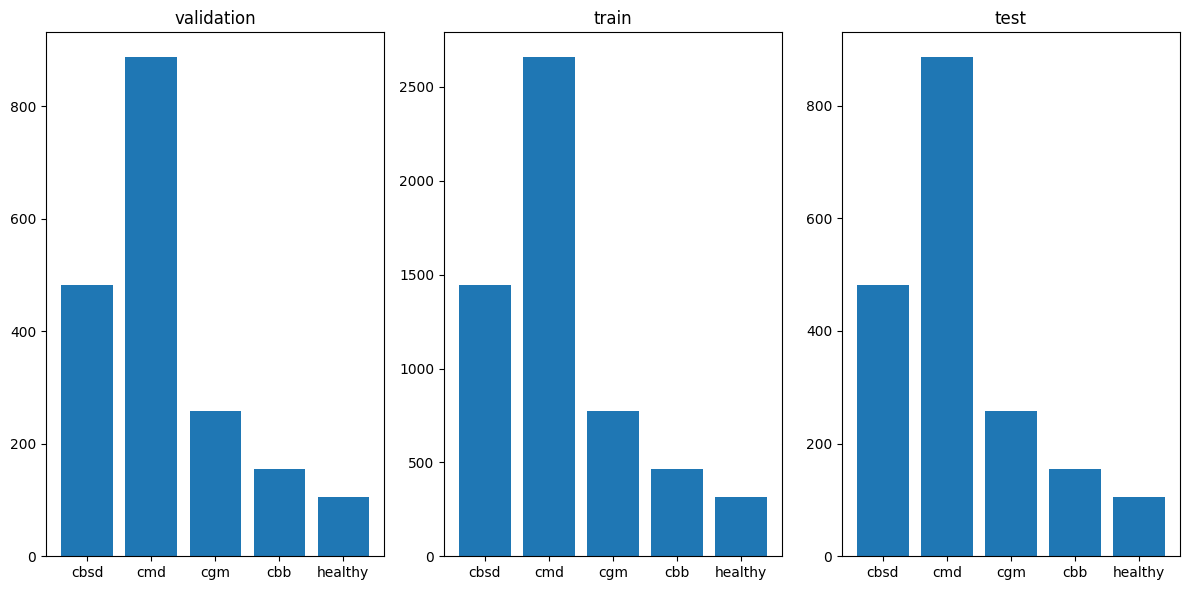

In [9]:
show_labels(base_dir)

In [10]:
def plot_images(data_dir, label, num_sample=6):
    data_dir = os.path.join(data_dir, label)
    image_files = list(paths.list_images(data_dir))[:num_sample]
    fig, ax = plt.subplots(2,num_sample//2, figsize=(14,7))
    for i, image_dir in enumerate(image_files):
        img = mpimg.imread(image_dir)
        label = image_dir.split('/')[-2]
        ax[i//(num_sample//2)][i%(num_sample//2)].imshow(img)
        ax[i//(num_sample//2)][i%(num_sample//2)].set_title(labels_dict[label])
        ax[i//(num_sample//2)][i%(num_sample//2)].axis('off')
    plt.tight_layout()
    plt.axis('off')
    plt.show()

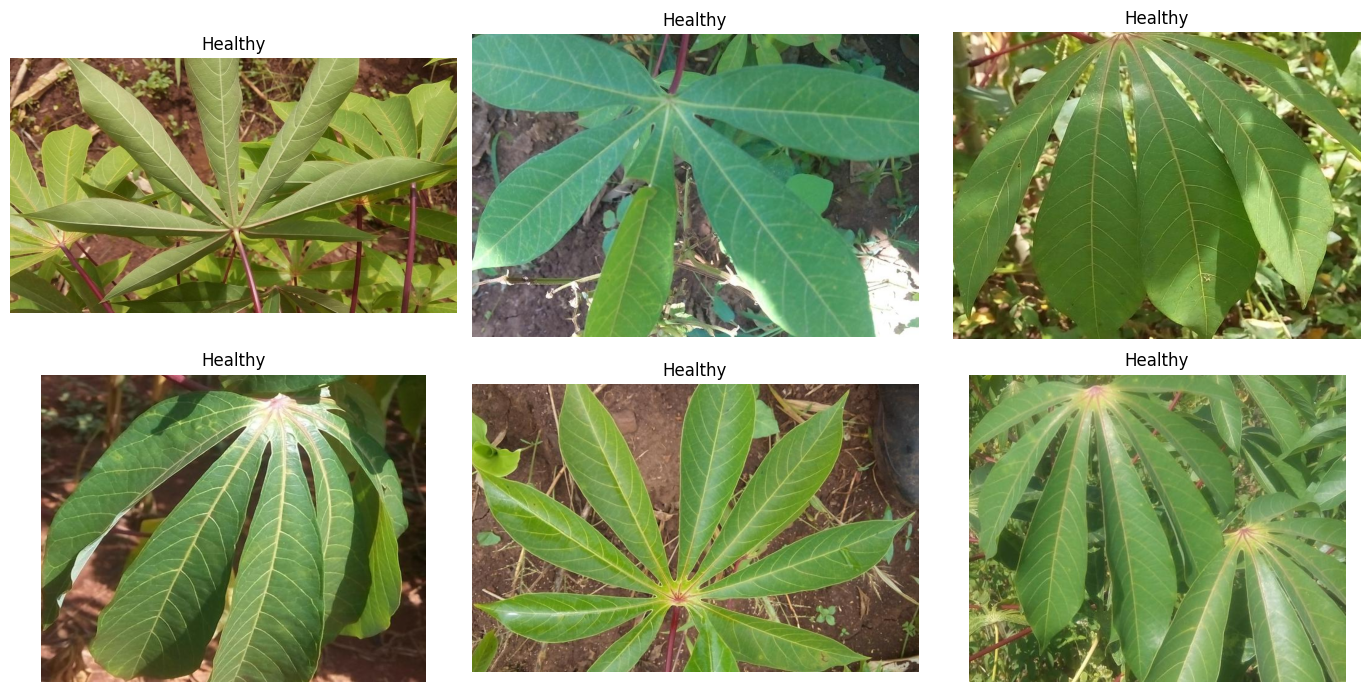

In [11]:
plot_images(train_dir, label="healthy")

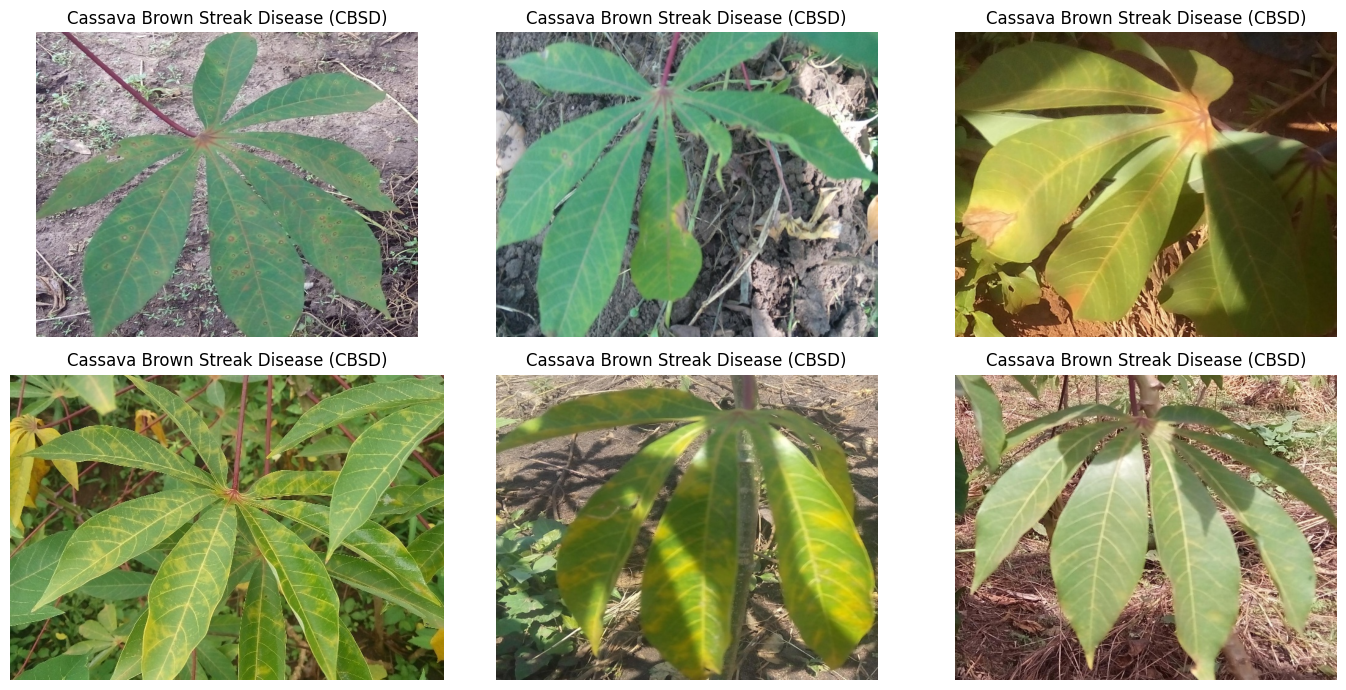

In [12]:
plot_images(train_dir, label="cbsd")

# 2. Preprocessing and Augmentation

In [13]:
img_size = 150
output_size = 5
batch_size = 128

In [14]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest" )

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_dataloader = train_datagen.flow_from_directory(train_dir,
                                                     batch_size=batch_size,
                                                     target_size=(img_size, img_size))

valid_dataloader = val_datagen.flow_from_directory(valid_dir,
                                         batch_size=batch_size,
                                         target_size=(img_size, img_size))

test_dataloader = test_datagen.flow_from_directory(test_dir,
                                           batch_size=batch_size,
                                           shuffle = False,
                                           target_size=(img_size, img_size))

Found 5656 images belonging to 5 classes.
Found 1889 images belonging to 5 classes.
Found 1885 images belonging to 5 classes.


In [15]:
def show_aug(images):
    fig, axis = plt.subplots(1, 5, figsize=(20, 20))
    axis = axis.flatten()
    for img, ax in zip(images, axis):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [16]:
imgs = [train_dataloader[0][0][0] for i in range(5)]

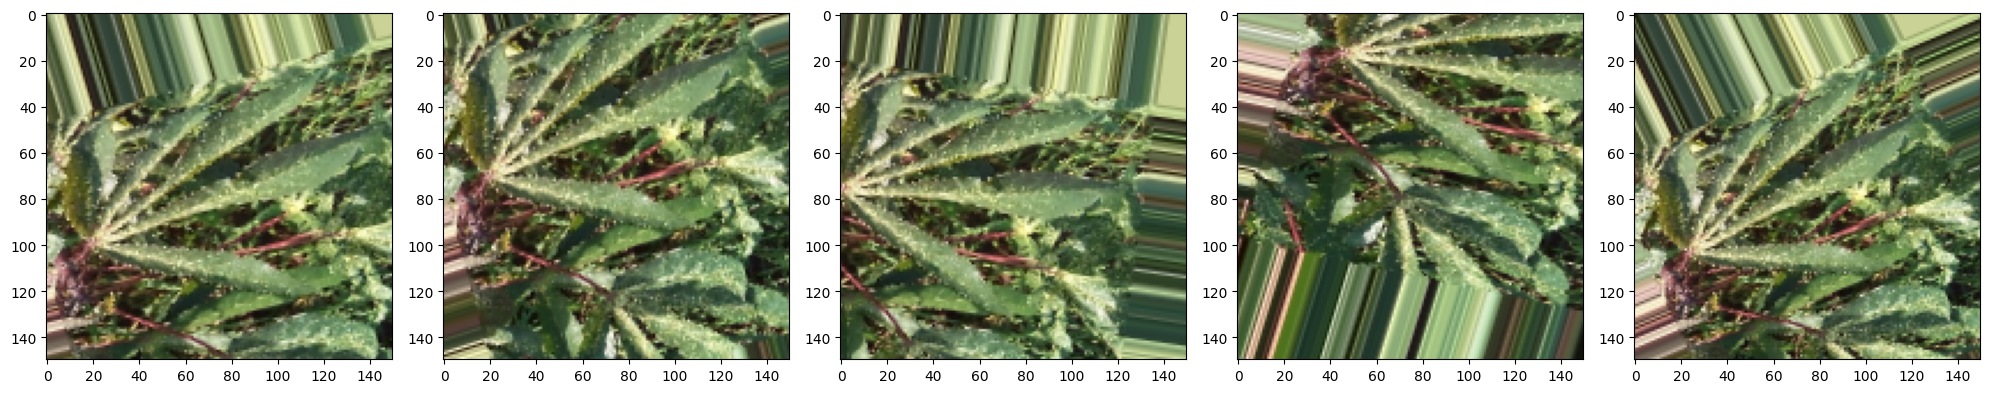

In [17]:
show_aug(imgs)

# 3. Model tuning with keras tuner

In [18]:
def build_model(hp):
    # Define the input shape
    input_shape = (150, 150, 3)

    # Start building the model
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Define hyperparameters
    activation = hp.Choice('activation', values=['relu', 'leaky_relu'])
    use_dropout = hp.Boolean('use_dropout')

    # Define the number of filters for each layer
    filters = []
    for i in range(4):
        filters.append(hp.Int(f'filters_{i}', min_value=32, max_value=512, step=32))

    # Initial convolution layer
    x = layers.Conv2D(filters[0], 7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual blocks
    for i in range(4):
        # Identity block
        for _ in range(2):
            shortcut = x

            # 3x3 convolutional layers
            x = layers.Conv2D(filters[i], 3, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation(activation)(x)

            # Check if dropout is enabled
            if use_dropout:
                x = layers.Dropout(0.25)(x)

            x = layers.Conv2D(filters[i], 3, padding='same')(x)
            x = layers.BatchNormalization()(x)

            # Check if skip connections are enabled
            x = layers.Add()([x, shortcut])
            x = layers.Activation(activation)(x)

        # Downsampling block
        if i < 3:
            x = layers.Conv2D(filters[i+1], 1, strides=2, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation(activation)(x)

    # Flatten and output layer
    x = layers.Flatten()(x)
    outputs = layers.Dense(output_size, activation='softmax')(x)

    # Build the model
    model = keras.Model(inputs, outputs)

    # Define the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [19]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='project_2',
    project_name='resnet18')

In [20]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu'], 'ordered': False}
use_dropout (Boolean)
{'default': False, 'conditions': []}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
filters_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}


In [ ]:
tuner.search(train_dataloader, epochs=10, validation_data=valid_dataloader)

Trial 2 Complete [00h 12m 30s]
val_accuracy: 0.5685548186302185

Best val_accuracy So Far: 0.5685548186302185
Total elapsed time: 00h 25m 57s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
relu              |leaky_relu        |activation
True              |False             |use_dropout
32                |32                |filters_0
128               |192               |filters_1
192               |384               |filters_2
480               |320               |filters_3
1e-05             |1e-05             |learning_rate

Epoch 1/10
45/45 [==============================] - 77s 1s/step - loss: 1.8260 - accuracy: 0.3746 - val_loss: 1.5530 - val_accuracy: 0.3504
Epoch 2/10
45/45 [==============================] - 62s 1s/step - loss: 1.7452 - accuracy: 0.3837 - val_loss: 1.5797 - val_accuracy: 0.2552
Epoch 3/10
45/45 [==============================] - 62s 1s/step - loss: 1.7390 - accuracy: 0.3907 - val_loss: 1.6993 - val_accuracy: 0.2552
Epoch 4/10
45/

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
history = model.fit(train_dataloader, epochs=40, validation_data=valid_dataloader)

In [ ]:

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['Accuracy'], label = 'train_Accuracy')
plt.plot(history.history['val_Accuracy'], label = 'val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataloader)